# Regresión logística aplicada a Olivetti

## 1. Lectura y partición:




In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Descargar Olivetti
print("Descargando dataset Olivetti...")
olivetti = fetch_olivetti_faces()
X = olivetti.data
y = olivetti.target

# 2. Split (Train/Test)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 3. Escalado (Vital para que converja rápido)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train: {X_train.shape} (4096 características por cara)")

Descargando dataset Olivetti...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
X_train: (280, 4096) (4096 características por cara)


## 2. Regresión logística

Usamos la implementación de regresión logística (clase [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) de la librería [sklearn](https://scikit-learn.org/).

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Configurar
model = LogisticRegression(max_iter=3000, random_state=42)

# 2. Entrenar
print("Entrenando... (esto puede tardar unos segundos)")
model.fit(X_train, y_train)

# 3. Evaluar
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Tasa de Acierto (Accuracy) en Test: {acc:.2%}")

Entrenando... (esto puede tardar unos segundos)
Tasa de Acierto (Accuracy) en Test: 97.50%


## 3. Ajuste de hiperparámetros

A continuación se describen algunos hiperparámetros del [método constructor `LogisticRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) que pueden ser ajustados experimentalmente para minimzar la tasa de error en test.

### 3.1 Tolerancia

Como sabemos, el algoritmo de descenso por gradiente actualiza en cada iteración los parámetros del modelo:

$$\boldsymbol{W}_{i+1}=\boldsymbol{W}_i-\eta_i\boldsymbol{\nabla}\mathcal{L}(\boldsymbol{W})\rvert_{\boldsymbol{W}_i}\qquad i=0,1,\ldots$$

El parámetro `tol` establece el umbral de tolerancia mínimo necesario para continuar dicho entrenamiento. Si la magnitud de actualización de parámetros $\Delta = \lVert \,  \eta_i\boldsymbol{\nabla}\mathcal{L}(\boldsymbol{\theta})\rvert_{\boldsymbol{\theta}_i} \, \rVert$ es inferior a `tol` ($\Delta < $ `tol`), el entrenamiento finaliza. Por defecto, `tol = 1e-4`.

In [3]:
for tol in (1e-4, 1e-2, 1, 1e2, 1e4):
    model = LogisticRegression(tol=tol, random_state=22).fit(X_train, y_train)
    err_test = 1 - accuracy_score(y_test, model.predict(X_test))
    print(f"Error de test con tolerancia {tol}: {err_test:.1%}")

Error de test con tolerancia 0.0001: 2.5%
Error de test con tolerancia 0.01: 9.2%
Error de test con tolerancia 1: 97.5%
Error de test con tolerancia 100.0: 97.5%
Error de test con tolerancia 10000.0: 97.5%


### 3.2 Regularización

La regularización en aprendizaje automático es una técnica utilizada para evitar el sobreajuste (overfitting) de los modelos. El sobreajuste ocurre cuando un modelo se ajusta demasiado a los datos de entrenamiento, pero falla en generalizar a nuevos datos. La regularización introduce una penalización o coste adicional en la función de riesgo empírico o pérdida $\mathcal{L}(\mathbf{\theta})$, desincentivando la complejidad excesiva del modelo (p.e. pesos $w_k$ demasiado grandes) y forzándolo a enfocarse en patrones más generales.

En regresión logística, reescribimos la función de riesgo empírico $\mathcal{L}$ como la $\operatorname{NLL}(\mathbf{W})$, a la que se añade un término o función regularizadora $r(\mathbf{W})$ escalada con un hiperparámetro de ajuste $C$:

$$ \mathcal{L}(\mathbf{W}) = \operatorname{NLL}(\mathbf{W}) + \frac{r(\mathbf{W})}{C} $$

`LogisticRegression` añade por defecto una regularización del criterio de entrenamiento basada en la norma $\ell_2$:

$$ r(\mathbf{W}) = \lambda \, \lVert \mathbf{W} \rVert_2^2$$

con $\lambda = \frac{1}{2}$ (más detalles [aquí](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)). Entonces:

$$ \mathcal{L}(\mathbf{W}) = \operatorname{NLL}(\mathbf{W}) +  \frac{\frac{1}{2} \, \lVert \mathbf{W} \rVert_2^2}{C} = \operatorname{NLL}(\mathbf{W}) + \frac{\sum_{i=0}^D \sum_{j=1}^{K} \mathbf{W}_{i,j}^2}{2C}$$

El propósito de esta regularización es evitar un sobre-ajuste del modelo a los datos de entrenamiento, apostando por unos parámetros más sencillos (más próximos a cero):

$$\mathbf{W}^*=\operatorname*{argmin}_{\mathbf{W}}\;\mathcal{L}(\mathbf{W}) = \operatorname{NLL}(\mathbf{W}) + \frac{\sum_{i=0}^D \sum_{j=0}^{K-1} \mathbf{W}_{i,j}^2}{2C} $$

El hiperparámetro $C$ (positivo, $1.0$ por defecto) permite ajustar a la inversa la magnitud de dicha regularización:
* **Máxima regularización** (sub-ajuste a los datos de train): $\;$ con un valor de `C` próximo a cero.
* **Mínima regularización** (sobre-ajuste a los datos de train): $\;$ con un valor de `C` positivo muy alto.

In [7]:
for C in (1e-3, 1e-2, 1e-1, 1, 1e1, 1e2):
    model = LogisticRegression(C=C, random_state=22, max_iter=3000).fit(X_train, y_train)
    err_test = 1 - accuracy_score(y_test, model.predict(X_test))
    print(f"Error de test con C {C:g}: {err_test:.1%}")

Error de test con C 0.001: 5.0%
Error de test con C 0.01: 2.5%
Error de test con C 0.1: 2.5%
Error de test con C 1: 2.5%
Error de test con C 10: 2.5%
Error de test con C 100: 2.5%


### 3.3 Número de iteraciones máximas

El parámetro `max_iter`  permite ajustar el número total de iteraciones del algoritmo de optimización. Ajustaremos este número basándonos en el criterio *Early stopping*: detenemos el entrenamiento lo más pronto posible (en pocas iteraciones) para evitar un sobre-entrenamiento del modelo.

In [5]:
for max_iter in (10, 20, 50, 100):
    model = LogisticRegression(random_state=22, max_iter=max_iter).fit(X_train, y_train)
    err_test = 1 - accuracy_score(y_test, model.predict(X_test))
    print(f"Error de test con max_iter {max_iter}: {err_test:.1%}")

Error de test con max_iter 10: 4.2%
Error de test con max_iter 20: 2.5%
Error de test con max_iter 50: 2.5%
Error de test con max_iter 100: 2.5%


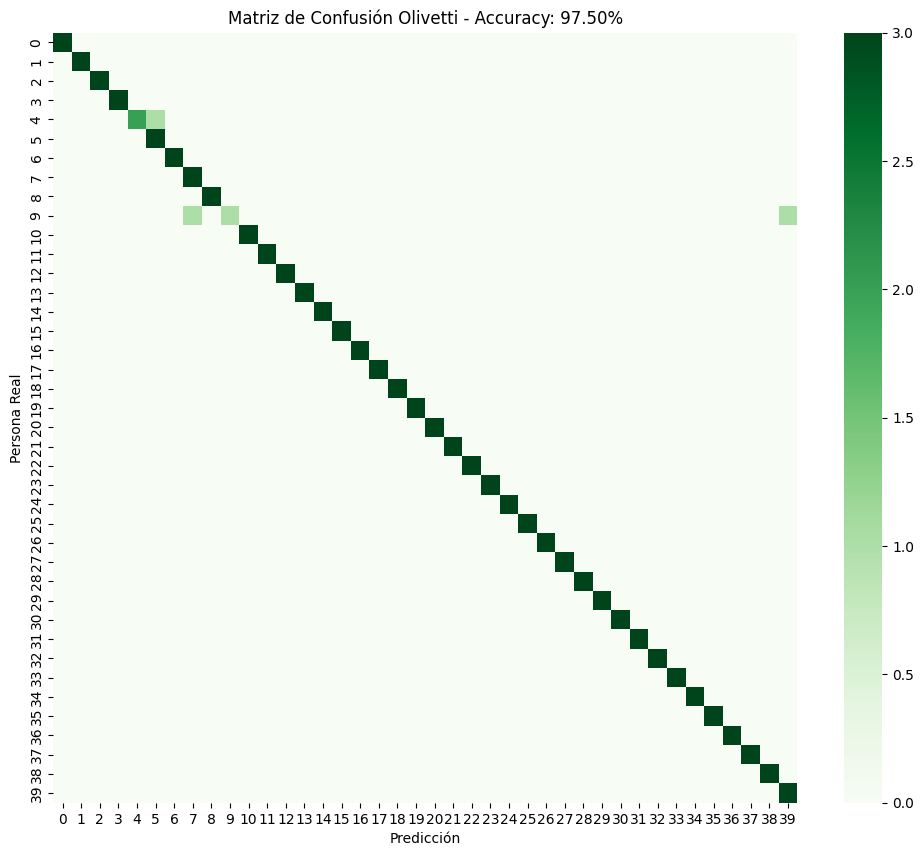

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10)) # Tamaño grande para 40 clases
sns.heatmap(cm, cmap='Greens', annot=False) # annot=False para que no se vea sucio
plt.title(f'Matriz de Confusión Olivetti - Accuracy: {acc:.2%}')
plt.ylabel('Persona Real')
plt.xlabel('Predicción')
plt.show()